# 3. Convolutional AutoEncoder MNIST

Reference: https://www.youtube.com/watch?v=P2lYhhCZ0Vg

## Input libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# TensorFlow
import tensorflow as tf

In [3]:
# Keras
from keras.datasets import mnist

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [4]:
# Other Libraries
import numpy as np
import matplotlib.pyplot as plt

import visualkeras

import os
import visualkeras
from PIL import ImageFont

In [5]:
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf" # change this to the path of the font file in your system
font = ImageFont.truetype(font_path, 12)

file_path = "/home/roderickperez/DS_projects/autoencoders/images/MNIST"

In [6]:
# Check if GPU is available
devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(devices))

Num GPUs Available:  1


### Load Dataset

In [7]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

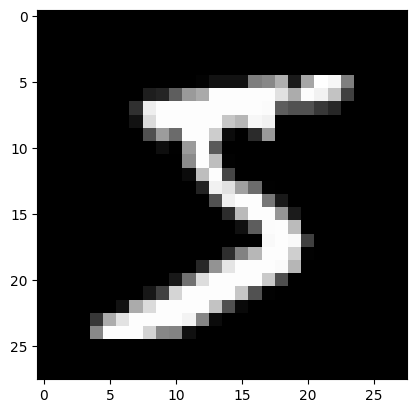

In [8]:
# Visualize one image
plt.imshow(X_train[0], cmap='gray')

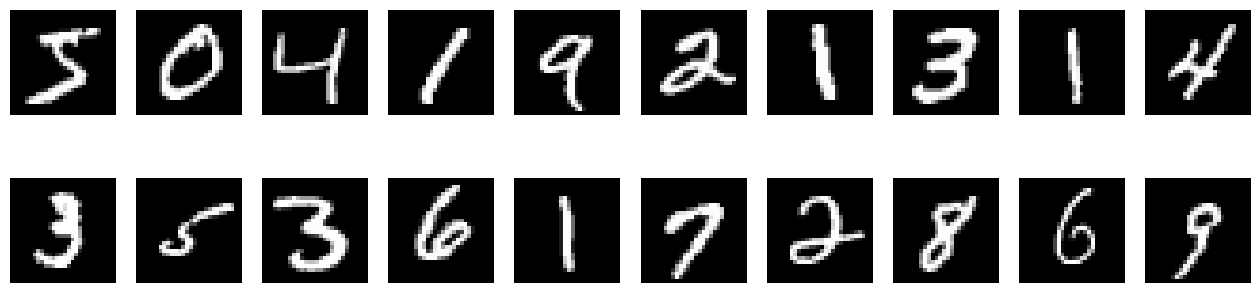

In [9]:
fig, axes = plt.subplots(2, 10, figsize=(16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i, j].imshow(X_train[count], cmap='gray')
        axes[i, j].axis('off')
        count += 1

### Preprocess the data

In [10]:
X_train[0].shape[0]

28

In [11]:
X_train.shape[0]

60000

In [12]:
28*28

784

In [13]:
X_train.shape

(60000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

x_train contains 60000 images of 28x28 pixels each. Now, we need to flatten the images into vectors of 28x28 = 784 pixels each. The result is that x_train will be a matrix of 6000 x 784 (28*28). We will repeat the same for x_test 10000 x 784 (28*28).

In [15]:
X_test[0].shape[1]

28

Normalize the data dividing the dataset by the max number, in this case 255.

In [16]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Check if the values are between 0 and 1.

In [17]:
X_train.max()

1.0

In [18]:
X_train.shape[0]

60000

In [19]:
X_train.shape[1]

28

### Add noise to the data

In [20]:
noise_factor = 0.1
X_train_noise = X_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [21]:
X_train_noise.shape

(60000, 28, 28)

In [22]:
X_test_noise.shape

(10000, 28, 28)

### Visualize noisy images

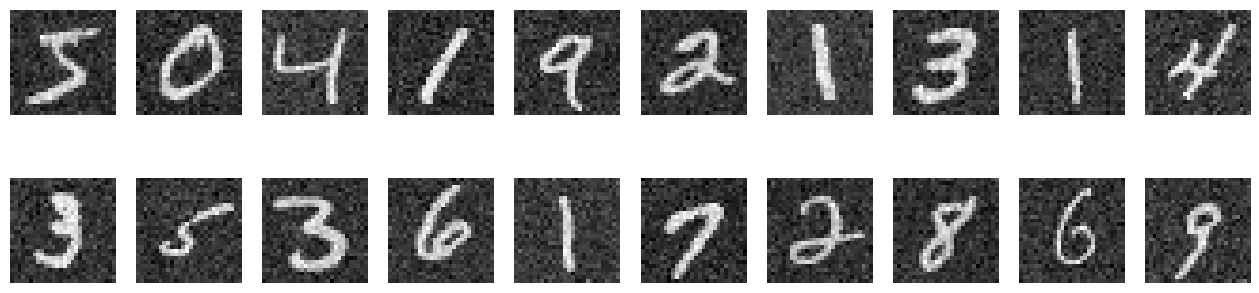

In [23]:
fig, axes = plt.subplots(2, 10, figsize=(16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i, j].imshow(X_train_noise[count], cmap='gray')
        axes[i, j].axis('off')
        count += 1

### Reshape the dataset

In [24]:
# Convert 2D image into 1D vector
X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0], X_train[0].shape[1], 1)
X_train.shape

(60000, 28, 28, 1)

In [25]:
X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[1], X_test[0].shape[1], 1)
X_test.shape

(10000, 28, 28, 1)

In [26]:
# Convert 2D image into 1D vector
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], X_train_noise[0].shape[0], X_train_noise[0].shape[1], 1)
X_train_noise.shape

(60000, 28, 28, 1)

In [27]:
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], X_test_noise[0].shape[1], X_test_noise[0].shape[1], 1)
X_test_noise.shape

(10000, 28, 28, 1)

## Model

In [28]:
X_train.shape[0]

60000

In [44]:
# Encoder Input Layer
encoder_input = Input(shape=X_train.shape[1:]) #28, 28, 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input) # (6000, 28, 28, 32)
x = BatchNormalization()(x)
x = MaxPool2D((2, 2), padding='same')(x) # (6000, 14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # (6000, 14, 14, 32)
x = BatchNormalization()(x)
encoded = MaxPool2D((2, 2), padding='same')(x) # (6000, 7, 7, 32)

In [45]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded) # (6000, 7, 7, 32)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x) # (6000, 14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # (6000, 14, 14, 32)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x) # (6000, 28, 28, 32)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # (6000, 28, 28, 1)

In [46]:
# Connect Layers intop the Model
autoencoder = Model(encoder_input, decoded, name = 'Denoising_Autoencoder')
autoencoder.summary()

Model: "Denoising_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 14, 14, 3

In [47]:
# Compile the model using MSE loss and Adam Optimizer
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

#### Train Model

In [48]:
# Fit training data to the model
checkpoint = ModelCheckpoint('../models/MNIST/DAE_MNIST_best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)
history = autoencoder.fit(X_train_noise, X_train, epochs=10, batch_size=256,  callbacks= checkpoint, validation_split = 0.25, verbose = 2)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.33870, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
176/176 - 4s - loss: 0.2435 - val_loss: 0.3387 - 4s/epoch - 22ms/step
Epoch 2/10

Epoch 2: val_loss improved from 0.33870 to 0.18031, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
176/176 - 2s - loss: 0.0842 - val_loss: 0.1803 - 2s/epoch - 9ms/step
Epoch 3/10

Epoch 3: val_loss improved from 0.18031 to 0.08363, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
176/176 - 2s - loss: 0.0769 - val_loss: 0.0836 - 2s/epoch - 9ms/step
Epoch 4/10

Epoch 4: val_loss improved from 0.08363 to 0.07491, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
176/176 - 1s - loss: 0.0745 - val_loss: 0.0749 - 1s/epoch - 8ms/step
Epoch 5/10

Epoch 5: val_loss improved from 0.07491 to 0.07341, saving model to ../models/MNIST/DAE_MNIST_best_model.h5
176/176 - 1s - loss: 0.0731 - val_loss: 0.0734 - 1s/epoch - 8ms/step
Epoch 6/10

Epoch 6: val_loss improved from 0.07341 to 0.0

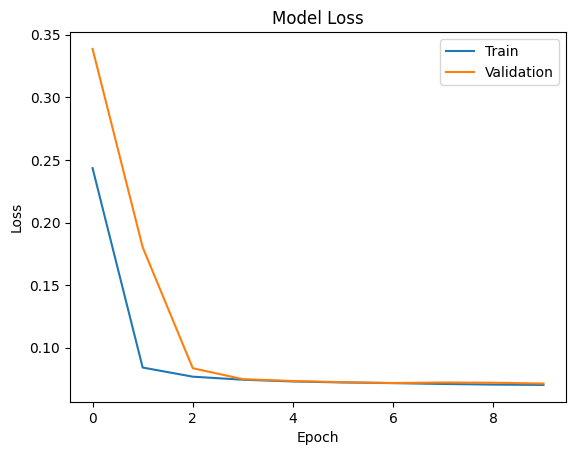

In [49]:
# Plot the training loss  and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Load BEST Model

In [50]:
from keras.models import load_model

autoencoder = load_model('../models/MNIST/DAE_MNIST_best_model.h5')
autoencoder.summary()

Model: "Denoising_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_5 (Bat  (None, 14, 14, 3

#### Visualize Data

In [51]:
def visualize_data(data):
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2])
    count = 0
    fig, axes = plt.subplots(2, 10, figsize=(16, 4))
    for i in range(2):
        for j in range(10):
            axes[i, j].imshow(data[count], cmap='gray')
            axes[i, j].axis('off')
            count += 1

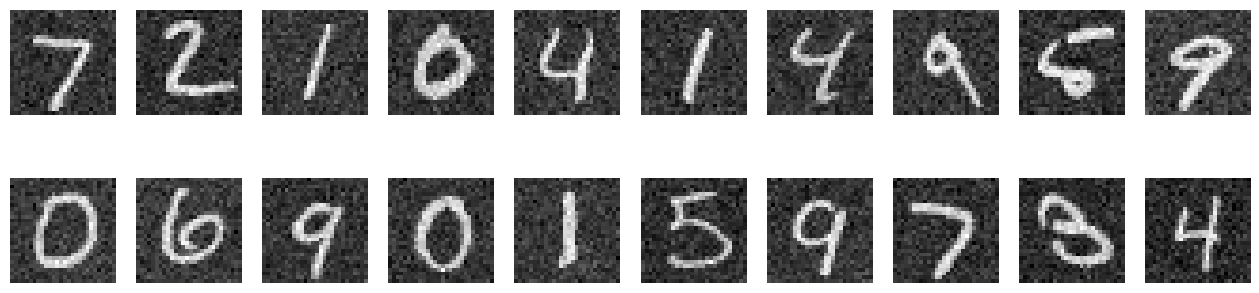

In [52]:
visualize_data(X_test_noise[:20])

In [53]:
# Predict on test noisy data
pred = autoencoder.predict(X_test_noise[:20])
pred.shape

1/1 [==============================] - 0s 81ms/step


(20, 28, 28, 1)

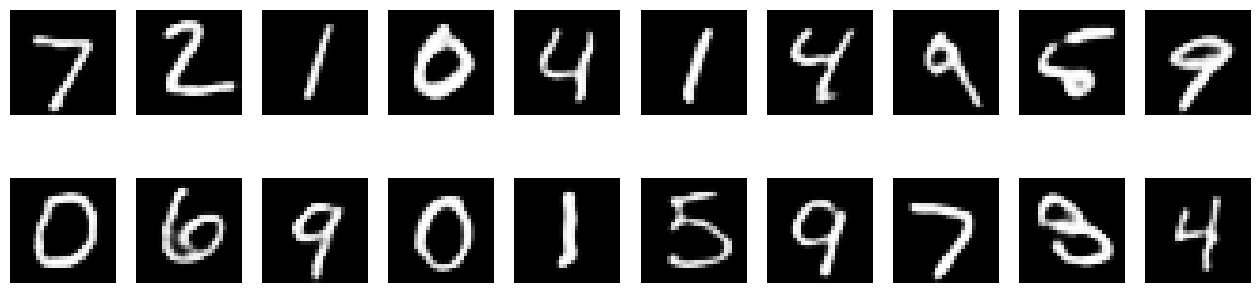

In [54]:
visualize_data(pred)

In [56]:
# Visualize Model
visualkeras.layered_view(autoencoder, legend=True, font=font, spacing=20).save(file_path + ".png") # save image to file | , scale_xy=1, scale_z=1, max_z=1000